# Q1

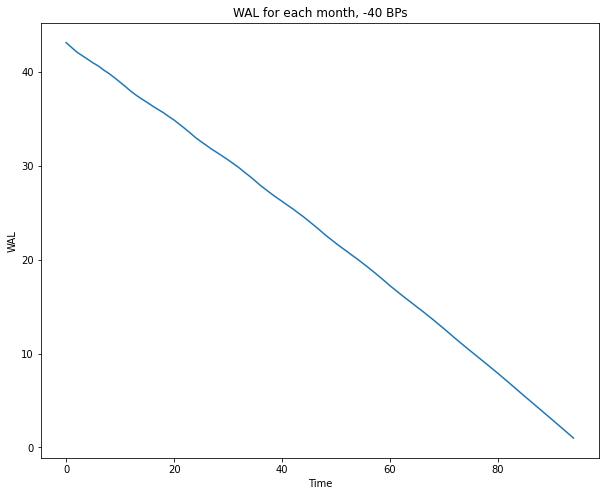

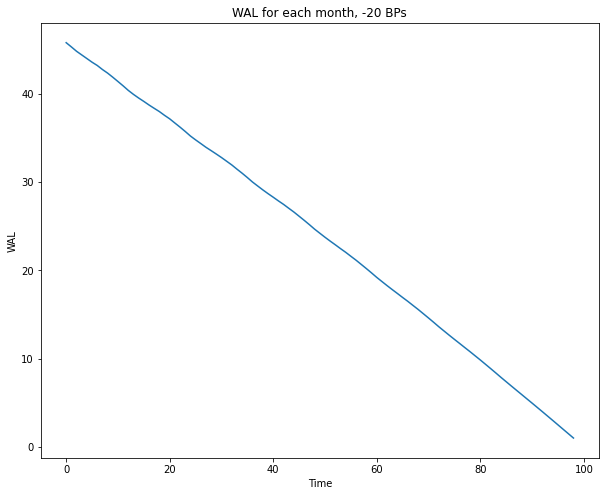

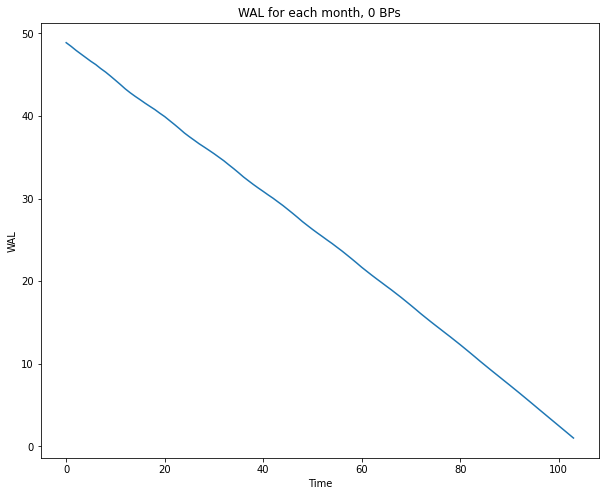

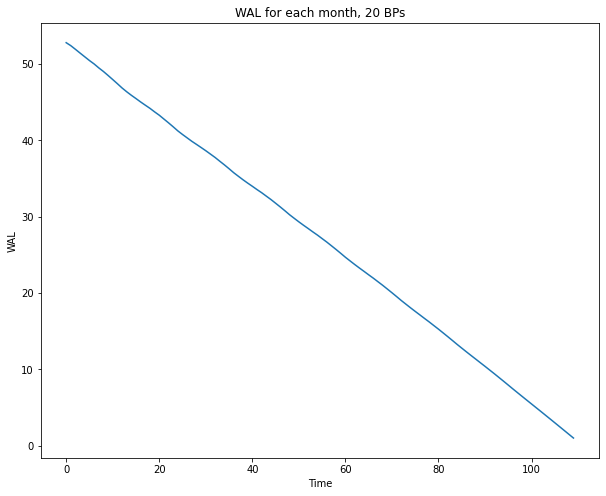

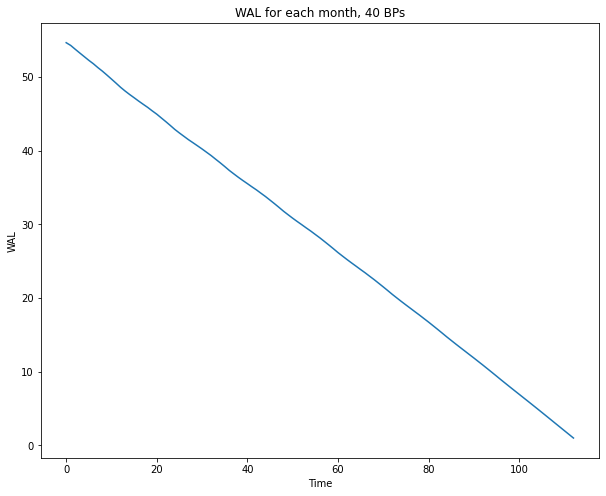

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# calculate SMM in first 33 months
c = 0.04075 / 12
net_c = 0.035 / 12
initial = 1030969738038
cur = 667058907009
m = 358
mthly_pymt = c * (1 + c) ** m / ((1 + c) ** m - 1) * initial

base_libor = pd.read_excel('HW4_data.xlsx', sheet_name='libor')
base_libor = np.array(base_libor['Spot']) * 0.01
CPR_data = pd.read_excel('HW4_data.xlsx', sheet_name='cpr')

def get_smm(cpr):
    smm = 1 - (1 - cpr * 0.01) ** (1 / 12)
    return smm

cash_flow_store = []
discount = []
for cpr in ['-40 BPs', '-20 BPs', '0 BPs', '20 BPs', '40 BPs']:
    cpr_data = CPR_data[cpr].to_list()
    r_change = int(cpr.split(' ')[0]) * 0.0001
    libor = base_libor + r_change
    discount.append(libor)
    principal_end = [cur]
    i = 0
    principal_pymt_his = []
    cash_flow = []
    while principal_end[-1] > 0.1:
        smm = get_smm(cpr_data[i])
        pymt = mthly_pymt + principal_end[-1] * smm
        cash_flow.append(pymt)
        interest = principal_end[-1] * net_c
        principal_pymt = pymt - interest
        principal_pymt_his.append(principal_pymt)
        principal_end.append(principal_end[-1] - principal_pymt)
        i += 1
    cash_flow_store.append(cash_flow)
    principal_pymt_his = np.array(principal_pymt_his)
    WAL = []
    for i in range(1, len(principal_pymt_his)):
        temp = np.sum(principal_pymt_his[i:] * np.linspace(1, len(principal_pymt_his) - i, len(principal_pymt_his) - i))
        WAL.append(temp / np.sum(principal_pymt_his[i:]))
    plt.figure(figsize=(10,8))
    plt.plot(WAL)
    plt.xlabel('Time')
    plt.ylabel('WAL')
    plt.title('WAL for each month, ' + cpr)
    plt.show()

In [2]:
def solve_oas(oas, price, cur_balance, cash_flow_store, discount):
    N = len(discount)
    PVs = []
    for i in range(N):
        temp = 0
        d = np.cumprod(1 + (discount[i]+oas)/12)
        cash_flow = cash_flow_store[i]
        for j in range(len(cash_flow)):
            temp += cash_flow[j] / d[j]
        PVs.append(temp)
    return (np.mean(PVs) - price/100*cur_balance)**2

In [3]:
from scipy import optimize
res = optimize.minimize_scalar(solve_oas, bounds=(-2,2),args=(100+7/32,cur,cash_flow_store,discount))
OAS = res.x
print('Solved OAS is {}'.format(round(OAS,4)))

Solved OAS is 0.01


# Q2

In [4]:
def get_PV(oas,shock=0):
    N = len(discount)
    PVs = []
    for i in range(N):
        temp = 0
        d = np.cumprod(1 + (discount[i]+oas+shock)/12)
        cash_flow = cash_flow_store[i]
        for j in range(len(cash_flow)):
            temp += cash_flow[j] / d[j]
        PVs.append(temp)
    
    return np.mean(PVs)

PV = get_PV(OAS)
print(PV)
PV01 = get_PV(OAS, 0.0001) - PV
PV_neg100 = get_PV(OAS, -0.01) - PV
PV_100 = get_PV(OAS, 0.01) - PV
print('PV01: ',PV01)
print('PV-100: ',PV_neg100)
print('PV100: ',PV_100)

668518098369.4161
PV01:  -248877582.07702637
PV-100:  25584902666.988525
PV100:  -24233006726.342285


**PV01**: -248.88 Million

**PV-100**: 25.58 Billion

**PV100**: -24.23 Billion

# Q3

In [5]:
CS_PV01 = get_PV(OAS+0.0001) - PV 
CS_PV_neg100 = get_PV(OAS-0.01) - PV
CS_PV_100 = get_PV(OAS+0.01) - PV
print('CS PV01: ',CS_PV01)
print('CS PV-100: ',CS_PV_neg100)
print('CS PV100: ',CS_PV_100)

CS PV01:  -248877582.07702637
CS PV-100:  25584902666.988525
CS PV100:  -24233006726.342285


**CS PV01**: -248.88 Million

**CS PV-100**: 25.58 Billion

**CS PV100**: -24.23 Billion

# Q4

In [6]:
PVs = []

for cpr in ['-140 BPs', '-120 BPs', '-100 BPs', '-80 BPs', '-60 BPs']:
    cpr_data = CPR_data[cpr].to_list()
    r_change = int(cpr.split(' ')[0]) * 0.0001
    libor = base_libor + r_change
    principal_end = [cur]
    i = 0
    cash_flow = []
    while principal_end[-1] > 0.1:
        smm = get_smm(cpr_data[i])
        pymt = mthly_pymt + principal_end[-1] * smm
        cash_flow.append(pymt)
        interest = principal_end[-1] * net_c
        principal_pymt = pymt - interest
        principal_end.append(principal_end[-1] - principal_pymt)
        i += 1
    d = np.cumprod(1 + (libor + OAS)/12)
    temp = 0
    for j in range(len(cash_flow)):
        temp += cash_flow[j] / d[j]
    PVs.append(temp)
    
PV_neg_changes = np.array(PVs) - PV
print('changes in PV for -100 shock: ', PV_neg_changes)

PVs = []

for cpr in ['60 BPs', '80 BPs', '100 BPs', '120 BPs', '140 BPs']:
    cpr_data = CPR_data[cpr].to_list()
    r_change = int(cpr.split(' ')[0]) * 0.0001
    libor = base_libor + r_change
    principal_end = [cur]
    i = 0
    cash_flow = []
    while principal_end[-1] > 0.1:
        smm = get_smm(cpr_data[i])
        pymt = mthly_pymt + principal_end[-1] * smm
        cash_flow.append(pymt)
        interest = principal_end[-1] * net_c
        principal_pymt = pymt - interest
        principal_end.append(principal_end[-1] - principal_pymt)
        i += 1
    d = np.cumprod(1 + (libor + OAS)/12)
    temp = 0
    for j in range(len(cash_flow)):
        temp += cash_flow[j] / d[j]
    PVs.append(temp)
    
PV_pos_changes = np.array(PVs) - PV
print('changes in PV for +100 shock: ', PV_pos_changes)

changes in PV for -100 shock:  [2.49854427e+10 2.31043342e+10 1.99342757e+10 1.77026715e+10
 1.49221215e+10]
changes in PV for +100 shock:  [-1.71866098e+10 -2.38315799e+10 -2.95582767e+10 -3.51041259e+10
 -4.08063780e+10]


# Q5

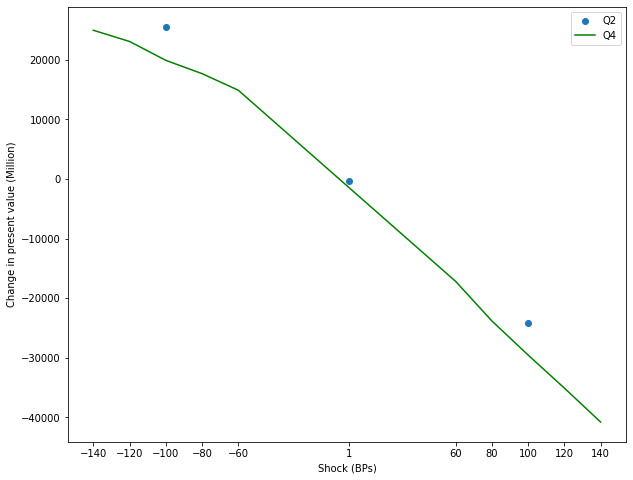

In [7]:
plt.figure(figsize=(10,8))
plt.scatter([-100,1,100], [PV_neg100/1e6, PV01/1e6, PV_100/1e6],label='Q2')
plt.plot(list(range(-140,-59,20))+list(range(60,141,20)), np.append(PV_neg_changes,PV_pos_changes)/1e6,label='Q4', color='green')
# ticks array-like, optional The list of xtick locations. Passing an empty list removes all xticks.
# labels array-like, optional The labels to place at the given ticks locations. 
plt.xticks(ticks=list(range(-140,-59,20))+[1]+ list(range(60,141,20)))
plt.xlabel('Shock (BPs)')
plt.ylabel('Change in present value (Million)')
plt.legend()
plt.show()

#### Why PV changes at -100, +100 are different for Q2 vs Q4?

Since in Q2, we assumed that CPRs stay the same when we shocked the rates, but in Q4, CPRs also changed when we shocked the rates. 

#### Describe the relationship of PV changes for Q3 to Q2 and Q4.


Q3 shares the same answer as Q2, since from the formula we can see that shock rates and shock OAS are basically equivalent since we use $r+OAS$ as the real rate to discount. Since Q3 is equivalent to Q2, Q2 is different to Q4 respect to CPRs, Q3 also differs from Q4 because of CPRs.